<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#读取数据集信息" data-toc-modified-id="读取数据集信息-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>读取数据集信息</a></span></li><li><span><a href="#提取dress类" data-toc-modified-id="提取dress类-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>提取dress类</a></span></li><li><span><a href="#读取图片数据" data-toc-modified-id="读取图片数据-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>读取图片数据</a></span></li><li><span><a href="#查看训练集图片" data-toc-modified-id="查看训练集图片-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>查看训练集图片</a></span></li></ul></li><li><span><a href="#数据增强" data-toc-modified-id="数据增强-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>数据增强</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#params" data-toc-modified-id="params-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>params</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Layers" data-toc-modified-id="Layers-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Layers</a></span></li><li><span><a href="#model" data-toc-modified-id="model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>model</a></span></li><li><span><a href="#loss" data-toc-modified-id="loss-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>loss</a></span></li><li><span><a href="#train" data-toc-modified-id="train-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>train</a></span></li></ul></li><li><span><a href="#Test" data-toc-modified-id="Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test</a></span><ul class="toc-item"><li><span><a href="#测试集" data-toc-modified-id="测试集-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>测试集</a></span></li><li><span><a href="#load-model" data-toc-modified-id="load-model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>load model</a></span></li></ul></li></ul></div>

Convolutional Pose Machines用于图片关键点定位，在低分辨率图像上，通过级联CNN，学习关键点标注。自然输出就是二维平面点的坐标。

https://arxiv.org/abs/1602.00134

开源实现：https://github.com/timctho/convolutional-pose-machines-tensorflow 对手掌检测进行了实验。模型训练需要比较大的显存

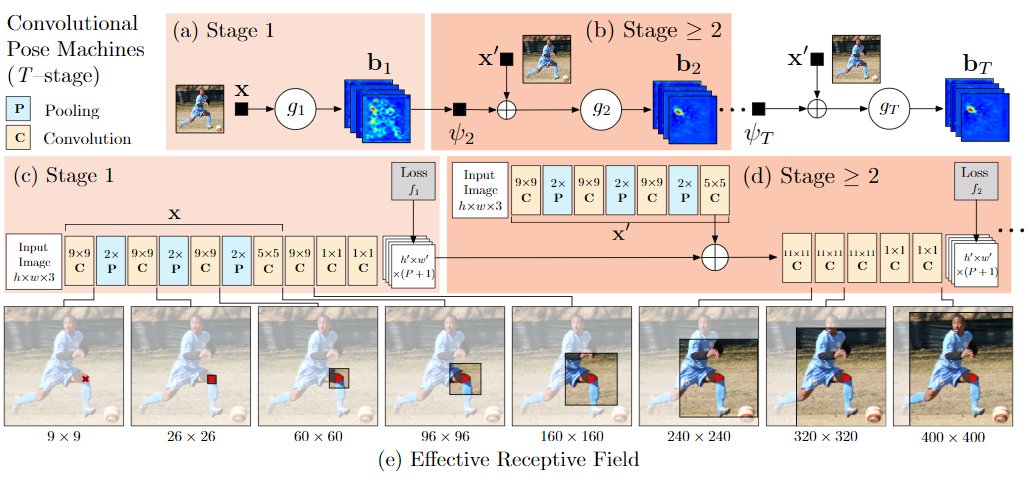

主要特点是，使用sequential  prediction，来学习图像在空间上的丰富信息。

主要问题：vanishing gradient。论文提出的方法是在不同stage都进行回归损失函数的计算。类似google net的思路，将损失信息强行BP。同时，在每个stage都会再次输入原图经过特征提取网络的低分辨率feature map信息

$$
f_{t}=\sum_{p=1}^{P+1} \sum_{z \in \mathcal{Z}}\left\|b_{t}^{p}(z)-b_{*}^{p}(z)\right\|_{2}^{2}
$$

损失函数中 t 是不同stage，P是图像不同区域。

### Data

天池FashionAI全球挑战赛数据（http://fashionai.alibaba.com/）

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave
import os
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#### 读取数据集信息

In [4]:
# 读取数据
train = pd.read_csv(os.path.join('data', 'train', 'train.csv'))
train_warm = pd.read_csv(os.path.join('data', 'train_warm', 'train_warm.csv'))
test = pd.read_csv(os.path.join('data', 'test', 'test.csv'))
print(len(train), len(train_warm), len(test))

columns = train.columns
print(len(columns), columns)

# 合并两个训练集
train['image_id'] = train['image_id'].apply(lambda x: os.path.join('train', x))
train_warm['image_id'] = train_warm['image_id'].apply(lambda x: os.path.join('train_warm', x))
train = pd.concat([train, train_warm])
del train_warm
train.sample(5)

31631 12534 9996
26 Index(['image_id', 'image_category', 'neckline_left', 'neckline_right',
       'center_front', 'shoulder_left', 'shoulder_right', 'armpit_left',
       'armpit_right', 'waistline_left', 'waistline_right', 'cuff_left_in',
       'cuff_left_out', 'cuff_right_in', 'cuff_right_out', 'top_hem_left',
       'top_hem_right', 'waistband_left', 'waistband_right', 'hemline_left',
       'hemline_right', 'crotch', 'bottom_left_in', 'bottom_left_out',
       'bottom_right_in', 'bottom_right_out'],
      dtype='object')


,image_id,image_category,neckline_left,neckline_right,center_front,shoulder_left,shoulder_right,armpit_left,armpit_right,waistline_left,...,top_hem_right,waistband_left,waistband_right,hemline_left,hemline_right,crotch,bottom_left_in,bottom_left_out,bottom_right_in,bottom_right_out
10180,train_warm\Images/trousers/ee3590d43f74c6f534a...,trousers,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,...,-1_-1_-1,141_17_1,305_16_1,-1_-1_-1,-1_-1_-1,218_161_1,179_484_1,101_471_1,280_484_1,349_470_1
15633,train\Images/outwear/44544846db14dbe88ef53d17d...,outwear,235_95_0,303_98_0,-1_-1_-1,207_108_1,325_113_1,210_184_0,344_180_0,222_240_1,...,354_490_1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1
21861,train\Images/dress/7df12dd186ab3e8ec22ee2c40b4...,dress,139_111_1,190_112_1,166_116_1,94_136_1,228_142_1,109_191_1,213_193_0,118_248_1,...,-1_-1_-1,-1_-1_-1,-1_-1_-1,98_486_1,215_488_1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1
16445,train\Images/outwear/b2e8d5e02f4e0163145de71b8...,outwear,187_28_1,223_23_1,-1_-1_-1,151_41_1,263_32_1,157_93_1,256_85_1,-1_-1_-1,...,269_263_1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1
20687,train\Images/dress/1a6859e0b36a1c7a53e59422e75...,dress,201_7_1,308_6_1,258_43_1,172_20_1,343_22_1,172_95_1,341_97_1,186_179_1,...,-1_-1_-1,-1_-1_-1,-1_-1_-1,137_428_1,380_430_1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1


#### 提取dress类

In [5]:
train = train[train.image_category == 'dress']
test = test[test.image_category == 'dress']
print(len(train), len(test))

# 新增关键点坐标列
for col in columns:
    if col in ['image_id', 'image_category']:
        continue
    train[col + '_x'] = train[col].apply(lambda x: float(x.split('_')[0]))
    train[col + '_y'] = train[col].apply(lambda x: float(x.split('_')[1]))
    train[col + '_s'] = train[col].apply(lambda x: float(x.split('_')[2]))
    train.drop([col], axis=1, inplace=True)
train.head()

7224 2038


,image_id,image_category,neckline_left_x,neckline_left_y,neckline_left_s,neckline_right_x,neckline_right_y,neckline_right_s,center_front_x,center_front_y,...,bottom_left_in_s,bottom_left_out_x,bottom_left_out_y,bottom_left_out_s,bottom_right_in_x,bottom_right_in_y,bottom_right_in_s,bottom_right_out_x,bottom_right_out_y,bottom_right_out_s
20372,train\Images/dress/dce89c2c4152d141a446043b5e5...,dress,195.0,142.0,1.0,256.0,164.0,0.0,216.0,191.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20373,train\Images/dress/2a05baa96b3ed8aac97f6f1908c...,dress,224.0,105.0,1.0,278.0,105.0,1.0,236.0,130.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20374,train\Images/dress/2b65284b9668d67295e57d2dec6...,dress,246.0,30.0,1.0,290.0,31.0,1.0,267.0,46.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20375,train\Images/dress/c35a9308f3c49c95e399fb7a783...,dress,227.0,35.0,0.0,283.0,32.0,0.0,255.0,52.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20376,train\Images/dress/d84c6f9bb133901a72297408dd0...,dress,231.0,108.0,0.0,279.0,105.0,1.0,264.0,125.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


#### 读取图片数据

In [6]:
# 转化为字典类型
features = [
    'neckline_left', 'neckline_right', 'center_front', 'shoulder_left',
    'shoulder_right', 'armpit_left', 'armpit_right', 'waistline_left',
    'waistline_right', 'cuff_left_in', 'cuff_left_out', 'cuff_right_in',
    'cuff_right_out', 'hemline_left', 'hemline_right'
]

train = train.to_dict('records')

for i in tqdm(range(len(train))):
    record = train[i]
    img = imread(os.path.join('data', record['image_id']))
    
    h = img.shape[0]
    w = img.shape[1]
    
    for col in features:
        if record[col + '_s'] >= 0:  # s：表示关键点可见
            train[i][col + '_x'] /= w
            train[i][col + '_y'] /= h
        else:
            train[i][col + '_x'] = 0
            train[i][col + '_y'] = 0

100%|██████████████████████████████████████| 7224/7224 [02:51<00:00, 42.11it/s]


#### 查看训练集图片

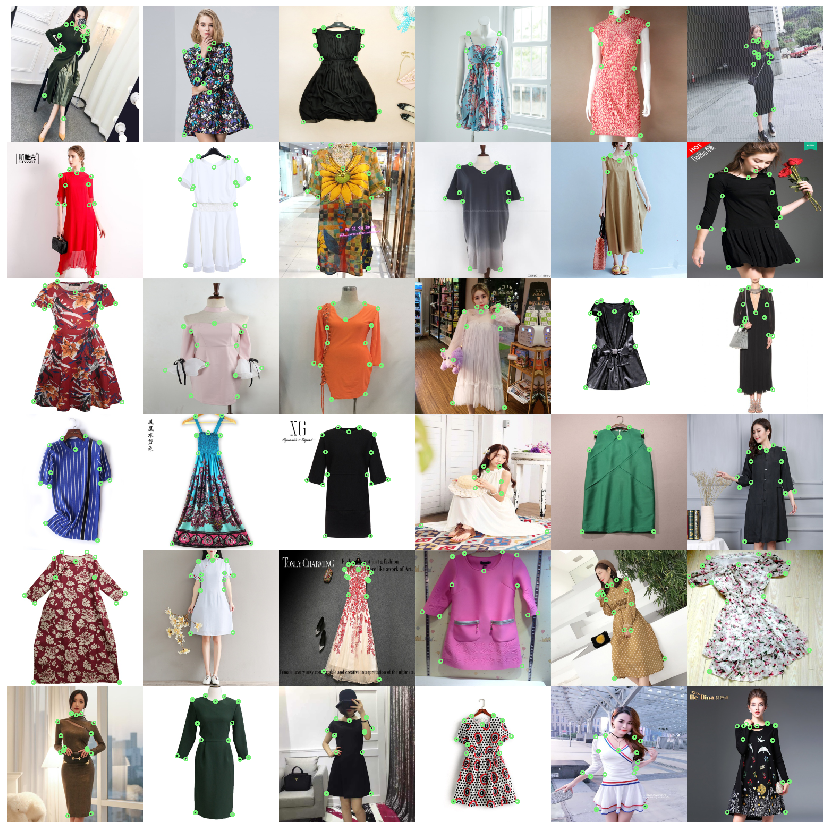

In [14]:
img_size = 256
r_ = 6  # 10行
c_ = 6  # 10列
total = r_ * c_

# 画布
puzzle = np.ones((img_size * r_, img_size * c_, 3))
# random sample
random_indexs = np.random.choice(len(train), total)

for i in range(total):
    record = train[random_indexs[i]]
    img = imread(os.path.join('data', record['image_id']))
    img = cv2.resize(img, (img_size, img_size))
    
    for col in features:
        if record[col + '_s'] >= 0:
            cv2.circle(img, 
                            (int(img_size * record[col + '_x']), int(img_size * record[col + '_y'])),
                            3,
                            (120, 240, 120), 
                            2)
    # [0, 1]
    img = img / 255.
    r = i // r_
    c = i % c_
    puzzle[r * img_size: (r + 1) * img_size, c * img_size: (c + 1) * img_size, : ] = img

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(puzzle)
plt.show()

### 数据增强

In [16]:
def precess_pic(offset_rot=20, offset_trans=20, flip_chance=0.5):
    X_data = []
    Y_data = []
    
    for i in range(X_batch.shape[0]):
        # -----------原图像变化------------
        img = X_batch[i]
        
        # random rotation  旋转
        # 旋转矩阵，白色填充
        degree = int(np.random.random() * offset_rot - offset_rot / 2)
        rad = degree / 180 * np.pi
        mat = cv2.getRotationMatrix2D((img_size / 2, img_size / 2), degree, 1)
        img_ = cv2.warpAffine(img, mat, (img_size, img_size), borderValue=(255, 255, 255))
        
        # random translation 平移
        x0 = int(np.random.random() * offset_trans - offset_trans / 2)
        y0 = int(np.random.random() * offset_trans - offset_trans / 2)
        mat = np.float32([[1, 0, x0], [0, 1, y0]])
        img_ = cv2.warpAffine(img_, mat, (img_size, img_size), borderValue=(255, 255, 255))
        
        # random flip  翻转
        if np.random.random() > flip_chance:
            img_ = np.fliplr(img_)
            flip = True
        else:
            flip = False
    
        X_data.append(img_)
        
        # -----------关键点变化------------
        points = []
        for j in range(y_dim):
            x = Y_batch[i, j, 0] * img_size
            y = Y_batch[i, j, 1] * img_size

            # random rotation
            dx = x - img_size / 2  
            dy = y - img_size / 2
            x = int(dx * np.cos(rad) + dy * np.sin(rad) + img_size / 2)  
            y = int(-dx * np.sin(rad) + dy * np.cos(rad) + img_size / 2)

            # random translation
            x += x0
            y += y0
            x = x / img_size
            y = y / img_size
            points.append([x, y])

        # random flip
        if flip:
            data = {features[j]: points[j] for j in range(y_dim)}
            points = []
            for j in range(y_dim):
                col = features[j]
                
                if col.find('left') >= 0:
                    col = col.replace('left', 'right')
                elif col.find('right') >= 0:
                    col = col.replace('right', 'left')
                # x变化，而y不变
                [x,  y] = data[col]
                x = 1 - x
                points.append([x, y])

        Y_data.append(points)    
    
    return X_data, Y_data

In [18]:
def transform(X_batch, Y_batch, heatmap_size=32):
    """数据增强，注意图像中有关键点，变换过程中关键点坐标同步变化"""
    
    X_data, Y_data = precess_pic(offset_rot=20, offset_trans=20, flip_chance=0.5)

    X_data = np.array(X_data)
    Y_data = np.array(Y_data)
    
    # preprocess
    X_data = (X_data / 255. - 0.5) * 2
    
    # 关键点热图处理
    Y_heatmap = []
    for i in range(Y_data.shape[0]):
        heatmaps = []
        invert_heatmap = np.ones((heatmap_size, heatmap_size))
        
        for j in range(Y_data.shape[1]):
            # 转换成heatmap_size的坐标
            x0 = int(Y_data[i, j, 0] * heatmap_size)
            y0 = int(Y_data[i, j, 1] * heatmap_size)
            
            x = np.arange(0, heatmap_size, 1, float)
            y = x[:, np.newaxis]
            
            # 当x, y与x0，y0（正确点）之间相差较小，cur_heatmap值更大
            cur_heatmap = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2.0 * 1.0 ** 2))
            # 每一个关键点都保存一张heatmap
            heatmaps.append(cur_heatmap)
            # 全局heatmap上，减去全部的关键点heatmap
            invert_heatmap -= cur_heatmap
        
        heatmaps.append(invert_heatmap)
        Y_heatmap.append(heatmaps)
    
    Y_heatmap = np.array(Y_heatmap)
    # batch_size, heatmap_size, heatmap_size, y_dim + 1
    Y_heatmap = np.transpose(Y_heatmap, (0, 2, 3, 1))
    
    return X_data, Y_data, Y_heatmap

### Model

#### params

In [36]:
# 参数
batch_size = 16
img_size = 256
heatmap_size = 32  # 识别热图的大小
stages = 6
epochs = 100
patience = 10  # early stopping

#### Input

In [ ]:
X_train = []
Y_train = []

for i in tqdm(range(len(train))):
    record = train[i]
    img = imread(os.path.join('data', record['image_id']))
    img = cv2.resize(img, (img_size, img_size))
    
    y = []
    for col in features:
        y.append([record[col + '_x'], record[col + '_y']])

    X_train.append(img)
    Y_train.append(y)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
print(X_train.shape)
print(Y_train.shape)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


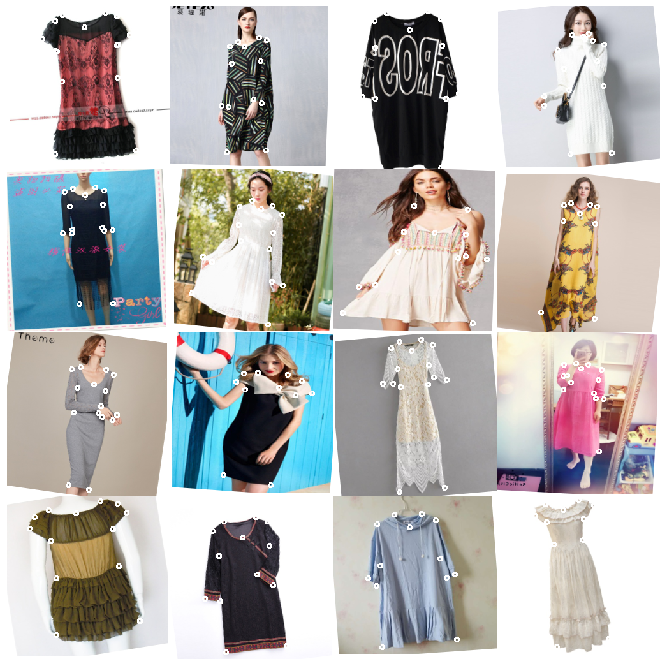

In [27]:
# 查看数据增强后的batch数据
X_batch = X_train[:batch_size]
Y_batch = Y_train[:batch_size]
# 数据增强
X_data, Y_data, Y_heatmap = transform(X_batch, Y_batch)

n = int(np.sqrt(batch_size))
puzzle = np.ones((img_size * n, img_size * n, 3))

for i in range(batch_size):
    img = (X_data[i] + 1) / 2
    for j in range(y_dim):
        cv2.circle(img,
                        (int(img_size * Y_data[i, j, 0]), int(img_size * Y_data[i, j, 1])),
                        3, 
                        (120, 240, 120), 
                        2)
    r = i // n
    c = i % n
    puzzle[r * img_size:(r + 1) * img_size, c * img_size:(c + 1) * img_size, : ] = img

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(puzzle)
plt.show()

In [24]:
# 一个关键点对应一个heatmap channel，同时还有一个全局背景heatmap channel
y_dim = Y_train.shape[1]

X = tf.placeholder(tf.float32, 
                              [None, img_size, img_size, 3], 
                              name='X')
# + 1：全局背景heatmap channel
Y = tf.placeholder(tf.float32, 
                              [None, heatmap_size, heatmap_size, y_dim + 1],
                              name='Y')

#### Layers

In [25]:
def conv2d(inputs,
           filters,
           kernel_size,
           padding='same',
           activation=tf.nn.relu,
           name=''):
    
    if name:
        return tf.layers.conv2d(
            inputs,
            filters=filters,
            kernel_size=kernel_size,
            strides=1,
            padding=padding,
            activation=activation,
            name=name,
            kernel_initializer=tf.contrib.layers.xavier_initializer())
    
    else:
        return tf.layers.conv2d(
            inputs,
            filters=filters,
            kernel_size=kernel_size,
            strides=1,
            padding=padding,
            activation=activation,
            kernel_initializer=tf.contrib.layers.xavier_initializer())


def maxpool2d(inputs):
    return tf.layers.max_pooling2d(inputs,
                                   pool_size=2,
                                   strides=2,
                                   padding='valid')

#### model

In [28]:
# 记录每个stage的输出
stage_heatmaps = []

# sub_stage：每个stage输入的图片特征中间状态
h0 = maxpool2d(conv2d(conv2d(X, 64, 3), 
                            64, 3))
h0 = maxpool2d(conv2d(conv2d(h0, 128, 3), 
                            128, 3))
h0 = maxpool2d(conv2d(conv2d(conv2d(conv2d(h0, 256, 3), 256, 3), 256, 3), 
                            256, 3))

for i in range(6):
    h0 = conv2d(h0, 512, 3)

# batch_size, 32, 32, 128
sub_stage = conv2d(h0, 128, 3)  

################ Main Stage#################
# stage_1
h0 = conv2d(sub_stage, 512, 1, padding='valid')
h0 = conv2d(h0, y_dim + 1, 1, padding='valid', activation=None, name='stage_1')
stage_heatmaps.append(h0)

# other stages
for stage in range(2, stages + 1):
    # 在输入图片特征
    h0 = tf.concat([stage_heatmaps[-1], sub_stage], axis=3)
    
    for i in range(5):
        h0 = conv2d(h0, 128, 7)
    
    h0 = conv2d(h0, 128, 1, padding='valid')
    h0 = conv2d(h0,
                          y_dim + 1,
                          1,
                          padding='valid',
                          activation=None,
                          name='stage_%d' % stage)
    
    stage_heatmaps.append(h0)

#### loss

In [29]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.001,
                                                                    global_step=global_step,
                                                                    decay_steps=1000,
                                                                    decay_rate=0.9)

losses = [0 for _ in range(stages)]
total_loss = 0

# 每个stage求损失
for stage in range(stages):
    losses[stage] = tf.losses.mean_squared_error(Y, stage_heatmaps[stage])
    total_loss += losses[stage]

# 正则
total_loss_with_reg = total_loss + tf.contrib.layers.apply_regularization(
        tf.contrib.layers.l2_regularizer(1e-10),  tf.trainable_variables())

total_loss = total_loss / stages
total_loss_with_reg = total_loss_with_reg / stages

optimizer = tf.contrib.layers.optimize_loss(total_loss_with_reg,
                                                                     global_step=global_step,
                                                                     learning_rate=learning_rate,
                                                                     optimizer='Adam',
                                                                     increment_global_step=True)

#### train

In [33]:
OUTPUT_DIR = 'output'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

# summary
for stage in range(stages):
    tf.summary.scalar('loss/loss_stage_%d' % (stage + 1), losses[stage])
tf.summary.scalar('loss/total_loss', total_loss)

summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(OUTPUT_DIR)

# 验证集上的最小损失，用于early stopping
loss_valid_min = np.inf
saver = tf.train.Saver()


def save_img(batch_first_img, stage_heatmaps_, heatmap_size, y_dim, output_dir, img_size=256):
    # 保存输出结果
    
    # [0, 1]
    img = (X_data[0] + 1) / 2
    heatmaps = []
    # 每个stage输出 heatmaps
    for stage in range(stages):
        heatmap = stage_heatmaps_[stage][0, :, :, :y_dim].reshape((heatmap_size, 
                                                                                                       heatmap_size, 
                                                                                                       y_dim))
        heatmap = cv2.resize(heatmap, (img_size, img_size))
        # 最大值的heatmap point的坐标，沿着channel
        heatmap = np.amax(heatmap, axis=2)
        heatmap = np.reshape(heatmap, (img_size, img_size, 1))
        heatmap = np.repeat(heatmap, 3, axis=2)
        heatmaps.append(heatmap)
    
    # 正确答案的heatmap 图处理
    gt_heatmap = Y_heatmap[0, :, :, :y_dim].reshape((heatmap_size, 
                                                                                   heatmap_size, 
                                                                                   y_dim))
    gt_heatmap = cv2.resize(gt_heatmap, (img_size, img_size))
    gt_heatmap = np.amax(gt_heatmap, axis=2)
    gt_heatmap = np.reshape(gt_heatmap, (img_size, img_size, 1))
    gt_heatmap = np.repeat(gt_heatmap, 3, axis=2)
    
    # 前三个stage输出叠加
    upper_img = np.concatenate((heatmaps[0], heatmaps[1], heatmaps[2]), axis=1)
    blend_img = 0.5 * img + 0.5 * gt_heatmap
    # 最后一个stage输出，一般效果更好，与原图混合
    lower_img = np.concatenate((heatmaps[-1], gt_heatmap, blend_img), axis=1)
    img = np.concatenate((upper_img, lower_img), axis=0)
    
    imsave(os.path.join(output_dir, 'sample_%d.jpg' % e), img)

In [ ]:
# train process

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for e in range(epochs):
    loss_train = []
    loss_valid = []
    
    # 训练
    X_train, Y_train = shuffle(X_train, Y_train)
    for i in tqdm(range(X_train.shape[0] // batch_size)):
        X_batch = X_train[i * batch_size: (i + 1) * batch_size, :, :, :]
        Y_batch = Y_train[i * batch_size: (i + 1) * batch_size, :, :]
        
        X_data, Y_data, Y_heatmap = transform(X_batch, Y_batch)
       
        _, los, lr, stage_heatmaps_ = sess.run([optimizer, total_loss, learning_rate, stage_heatmaps], 
                                                                feed_dict={X: X_data, Y: Y_heatmap})
        loss_train.append(los)
        
        # summary
        if i > 0 and i % 100 == 0:
            writer.add_summary(sess.run(summary, feed_dict={X: X_data, Y: Y_heatmap}), 
                               e * X_train.shape[0] // batch_size + i)
            writer.flush()
    
    # 验证
    X_valid, Y_valid = shuffle(X_valid, Y_valid)
    for i in range(X_valid.shape[0] // batch_size):
        X_batch = X_valid[i * batch_size: (i + 1) * batch_size, :, :, :]
        Y_batch = Y_valid[i * batch_size: (i + 1) * batch_size, :, :]
        X_data, Y_data, Y_heatmap = transform(X_batch, Y_batch)
        
        los = sess.run(total_loss, 
                               feed_dict={X: X_data, Y: Y_heatmap})
        loss_valid.append(los)
    
    # print
    loss_train = np.mean(loss_train)
    loss_valid = np.mean(loss_valid)
    print('Epoch %d, lr %.6f, train loss %.6f, valid loss %.6f' % (e, lr, loss_train, loss_valid))
    
    # save_img
    save_img(X_data[0], stage_heatmaps_, heatmap_size, y_dim, OUTPUT_DIR)
    
    # early stopping
    if loss_valid < loss_valid_min:
        print('Saving model...')
        saver.save(sess, os.path.join(OUTPUT_DIR, 'cpm'))
        loss_valid_min = loss_valid
        patience = 10  # 重置patience
    else:
        patience -= 1
        if patience == 0: break

### Test

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
from imageio import imread, imsave
import os

In [2]:
batch_size = 16
img_size = 256

stages = 6  # 提取该stage模型的tensor 
y_dim = 15
heatmap_size = 32

OUTPUT_DIR = 'output'

#### 测试集

In [3]:
test = pd.read_csv(os.path.join('data', 'test', 'test.csv'))

test['image_id'] = test['image_id'].apply(lambda x:os.path.join('test', x))
test = test[test.image_category == 'dress']
test = test['image_id'].values

test = shuffle(test)
test = test[:batch_size]

In [4]:
X_test = []

for i in range(batch_size):
    img = imread(os.path.join('data', test[i]))
    img = cv2.resize(img, (img_size, img_size))
    X_test.append(img)

X_test = np.array(X_test)
print(X_test.shape)

(16, 256, 256, 3)


#### load model

In [5]:
def visualize_result(imgs, heatmap, joints):
    """joints: 即关键点的数量，一个点对应一个heatmap channel"""
    imgs = imgs.astype(np.int32)
    
    coords = []
    for i in range(imgs.shape[0]):
        hp = heatmap[i, :, :, :joints].reshape((heatmap_size, heatmap_size, joints))
        hp = cv2.resize(hp, (img_size, img_size))
        coord = np.zeros((joints, 2))
        
        # 获取关键点坐标
        for j in range(joints):
            xy = np.unravel_index(np.argmax(hp[:, :, j]), (img_size, img_size))
            coord[j, :] = [xy[0], xy[1]]
            # xy[1]: 第0的axis，平面坐标系y轴对应
            # (120, 240, 120)： color
            cv2.circle(imgs[i], (xy[1], xy[0]), 3, (255, 0, 0), 2)

        coords.append(coord)
    
    return imgs / 255., coords


def show(batch_size, img_size, X_test):
    n = int(np.sqrt(batch_size))
    puzzle = np.ones((img_size * n, img_size * n, 3))
    for i in range(batch_size):
        img = X_test[i]
        r = i // n
        c = i % n
        puzzle[r * img_size: (r + 1) * img_size, c * img_size: (c + 1) * img_size, :] = img

    plt.figure(figsize=(12, 12))
    plt.imshow(puzzle)
    plt.show()
    imsave('result.jpg', puzzle)

INFO:tensorflow:Restoring parameters from output\cpm


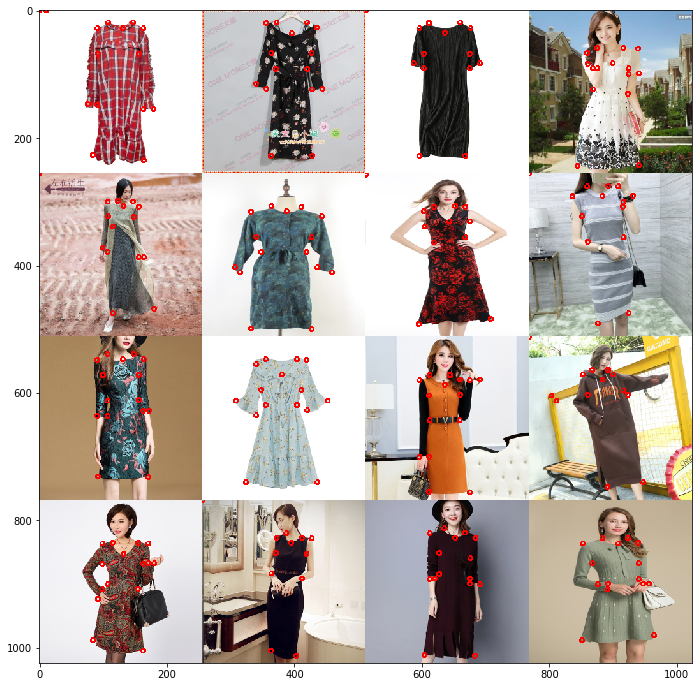

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph(os.path.join(OUTPUT_DIR, 'cpm.meta'))
saver.restore(sess, tf.train.latest_checkpoint(OUTPUT_DIR))

# get tensor
graph = tf.get_default_graph()
X = graph.get_tensor_by_name('X:0')
stage_heatmap = graph.get_tensor_by_name('stage_%d/BiasAdd:0' % stages)

# infer
heatmap = sess.run(stage_heatmap, feed_dict={X: (X_test / 255. - 0.5) * 2})
X_test, coords = visualize_result(X_test, heatmap, y_dim) 

# show result
show(batch_size, img_size, X_test)